In [1]:
#%pylab inline
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines 
import datetime as dt

In [2]:
import yatsm
from yatsm.io import read_pixel_timeseries
from yatsm.utils import csvfile_to_dataframe, get_image_IDs
from yatsm.config_parser import convert_config, parse_config_file
import yatsm._cyprep as cyprep

In [3]:
def plot_seasons(x, y, SEASONS):
    for season_months, color, alpha in SEASONS.values():
        season_idx = np.in1d(months, season_months)
        plt.plot(x[season_idx], y[season_idx], marker='o',
                 mec=color, mfc=color, alpha=alpha, ls='')

# Specify config and pixel to run

In [4]:
## SPECIFY CONFIG FILE
#config_file = '/projectnb/landsat/users/valpasq/LCMS/stacks/p045r030/p045r030_config_LCMS.yaml'
config_file = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config_pixel.yaml'

In [121]:
# SPECIFY PIXEL ROW AND COLUMN
WRS2 = 'p012r031'
py = 3051 # row 
px = 4857 # column
name = 'ShrubSwamp' # pixel name (for plot titles)

In [122]:
col_names = ['dt_date', 'date', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw']
band_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw', 'fmask']

In [123]:
# Set percentiles for range calculations
pct1=0.05
pct2=0.95

In [124]:
# Set date limits for TS plots
xmin = dt.datetime.strptime('1983 1', '%Y %j')
xmax = dt.datetime.strptime('2014 365', '%Y %j')

In [125]:
# Set seasons based on months
# dictionary = name, (months), color, alpha
SEASONS = {
    'winter': ((11, 12, 1, 2, 3), 'b', 0.5),
    'spring': ((4, 5), 'c', 0.5),
    'summer': ((6, 7, 8, 9), 'g', 0.5),
    'fall': ((10), 'y', 0.5)
}

# SETUP LEGEND 
# TODO: Make this more general! Can use dictionary above
winter = mlines.Line2D([], [], linewidth=0, color='b', marker='o',
                          markersize=4, label='Nov - Mar', alpha=0.8)
spring = mlines.Line2D([], [], linewidth=0, color='c', marker='o',
                          markersize=4, label='Apr / May', alpha=0.8)
summer = mlines.Line2D([], [], linewidth=0, color='g', marker='o',
                          markersize=4, label='Jun - Sept', alpha=0.8)
fall = mlines.Line2D([], [], linewidth=0, color='y', marker='o',
                          markersize=4, label='Oct', alpha=0.8)

# Read in config file and metadata

In [126]:
# Read in and parse config file
cfg = parse_config_file(config_file)

# Get files list
df = csvfile_to_dataframe(cfg['dataset']['input_file'], \
                          date_format=cfg['dataset']['date_format'])
# Get dates for image stack
df['image_ID'] = get_image_IDs(df['filename']) 

In [127]:
# Read in metadata 
metadata = pd.read_csv('/projectnb/landsat/projects/Massachusetts/p012r031/images/test_output.csv')

In [128]:
# Merge metadata with image df
df = pd.merge(df, metadata, on='image_ID', how='inner')

In [129]:
# Get dates, azimuth and elevation values
dates = df['date'].values
azimuth =  df[' azimuth'].values
elevation = df[' elevation'].values

# Read and mask time series

In [130]:
# Read in time series as numpy array
Y = read_pixel_timeseries(df['filename'], px, py)

# Write unmasked TS data and dates to CSV
TS=pd.DataFrame(Y.T, columns=band_names)
TS.insert(0, value=dates, column='date')
TS.insert(1, value=azimuth, column='azimuth')
TS.insert(2, value=elevation, column='elevation')
TS.to_csv('./example_data/{y}_{x}_{name}_TS-raw.csv'.format(x=px, y=py, name=name))

if (Y[0:6] == -9999).mean() > 0.3: # skip if TS is all nodata
    pass  # (this is really only necessary if running over entire image)

else: # process time series

    # Mask based on physical constraints and Fmask 
    valid = cyprep.get_valid_mask( \
                Y, \
                cfg['dataset']['min_values'], \
                cfg['dataset']['max_values']).astype(bool)

    # Apply mask band
    idx_mask = cfg['dataset']['mask_band'] - 1
    valid *= np.in1d(Y.take(idx_mask, axis=0), \
                             cfg['dataset']['mask_values'], \
                             invert=True).astype(np.bool)

    # Mask time series using fmask result
    Y_fmask = np.delete(Y, idx_mask, axis=0)[:, valid]
    dates_fmask = dates[valid]

    # Apply multi-temporal mask (modified tmask)
    # Step 1. mask where green > 3 stddev from mean (fmasked) green
    multitemp1_fmask = np.where(Y_fmask[1] < (np.mean(Y_fmask[1])+np.std(Y_fmask[1])*3))
    dates_fmask = dates_fmask[multitemp1_fmask[0]] 
    Y_fmask = Y_fmask[:, multitemp1_fmask[0]]
    # Step 2. mask where swir < 3 std devfrom mean (fmasked) SWIR
    multitemp2_fmask = np.where(Y_fmask[4] > (np.mean(Y_fmask[4])-np.std(Y_fmask[4])*3))
    dates_fmask = dates_fmask[multitemp2_fmask[0]] 
    Y_fmask = Y_fmask[:, multitemp2_fmask[0]]
    
    # convert SR x 10000 to float
    Y_fmask = Y_fmask.astype(float)/10000 

    # convert time from ordinal to dates
    dt_dates_fmask = np.array([dt.datetime.fromordinal(d) for d in dates_fmask])

    # Create dataframes for analysis 
    # Step 1. reshape data
    shp_ = dt_dates_fmask.shape[0]
    dt_dates_fmask_csv = dt_dates_fmask.reshape(shp_, 1)
    dates_fmask_csv = dates_fmask.reshape(shp_, 1)
    Y_fmask_csv = np.transpose(Y_fmask)
    data_fmask = np.concatenate([dt_dates_fmask_csv,dates_fmask_csv,Y_fmask_csv], axis=1)
    # Step 2. create dataframe
    data_fmask_df = pd.DataFrame(data_fmask, columns=col_names)
    # convert reflectance to numeric type
    data_fmask_df[band_names[0:10]] = data_fmask_df[band_names[0:10]].astype(float) 
    
print('Time series processing complete!')

Time series processing complete!


In [131]:
# Merge masked time series data with metadata
data_fmask_df = pd.merge(data_fmask_df, df, on='date', how='inner')

## WRITE TO CSV ##
data_fmask_df.to_csv('./example_data/{WRS2}_{y}_{x}_{name}_TS-masked.csv'.format(WRS2=WRS2, x=px, y=py, name=name))

# Visualize reflectance as a function of DOY and solar elevation

In [132]:
doy = np.array([d.timetuple().tm_yday for d in dt_dates_fmask])
year = np.array([d.year for d in dt_dates_fmask])
months = np.array([d.month for d in dt_dates_fmask])

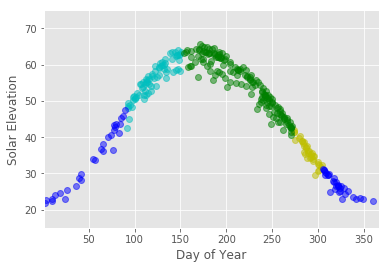

In [133]:
plt.style.use('ggplot')
plot_seasons(doy, data_fmask_df[' elevation'], SEASONS)
plt.savefig('./example_data/{WRS2}_{y}_{x}_DOYvSE_{name}.png'.format(WRS2=WRS2, x=px, y=py, name=name))
plt.ylim(15, 75)
plt.ylabel('Solar Elevation')
plt.xlim(1, 366)
plt.xlabel('Day of Year')
plt.show()

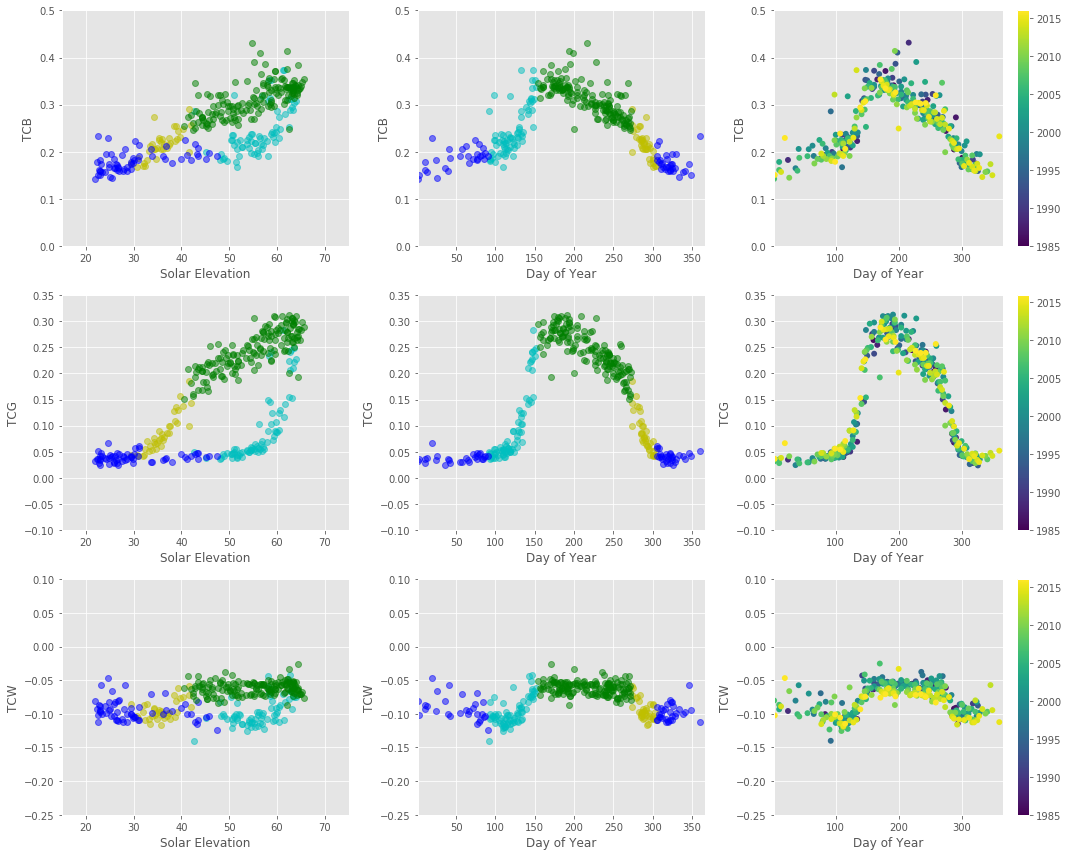

In [134]:
fig = plt.figure(figsize=(15,12),facecolor='w', edgecolor='k')
plt.style.use('ggplot')

ax = fig.add_subplot(331)
plot_seasons(data_fmask_df[' elevation'], data_fmask_df['tcb'], SEASONS)
plt.xlim(15, 75)
plt.xlabel('Solar Elevation')
plt.ylim(0, 0.5)
plt.ylabel('TCB')
    
ax = fig.add_subplot(332)
plot_seasons(doy, data_fmask_df['tcb'], SEASONS)
plt.tick_params(axis='x', which='minor', direction='in', pad=-10)
plt.xlim(1, 366)
plt.xlabel('Day of Year')
plt.ylim(0, 0.5)
plt.ylabel('TCB')

ax = fig.add_subplot(333)
sp = plt.scatter(doy, data_fmask_df['tcb'], c=year,
                     marker='o', edgecolors='none', s=35)
plt.colorbar(sp)
plt.xlim(1, 366)
plt.xlabel('Day of Year')
plt.ylim(0, 0.5)
plt.ylabel('TCB')

ax = fig.add_subplot(334)
plot_seasons(data_fmask_df[' elevation'], data_fmask_df['tcg'], SEASONS)
plt.xlim(15, 75)
plt.xlabel('Solar Elevation')
plt.ylim(-0.1, 0.35)
plt.ylabel('TCG')
    
ax = fig.add_subplot(335)
plot_seasons(doy, data_fmask_df['tcg'], SEASONS)
plt.tick_params(axis='x', which='minor', direction='in', pad=-10)
plt.xlim(1, 366)
plt.xlabel('Day of Year')
plt.ylim(-0.1, 0.35)
plt.ylabel('TCG')

ax = fig.add_subplot(336)
sp = plt.scatter(doy, data_fmask_df['tcg'], c=year,
                     marker='o', edgecolors='none', s=35)
plt.colorbar(sp)
plt.xlim(1, 366)
plt.xlabel('Day of Year')
plt.ylim(-0.1, 0.35)
plt.ylabel('TCG')

ax = fig.add_subplot(337)
plot_seasons(data_fmask_df[' elevation'], data_fmask_df['tcw'], SEASONS)
plt.xlim(15, 75)
plt.xlabel('Solar Elevation')
plt.ylim(-0.25, 0.1)
plt.ylabel('TCW')
    
ax = fig.add_subplot(338)
plot_seasons(doy, data_fmask_df['tcw'], SEASONS)
plt.tick_params(axis='x', which='minor', direction='in', pad=-10)
plt.xlim(1, 366)
plt.xlabel('Day of Year')
plt.ylim(-0.25, 0.1)
plt.ylabel('TCW')

ax = fig.add_subplot(339)
sp = plt.scatter(doy, data_fmask_df['tcw'], c=year,
                     marker='o', edgecolors='none', s=35)
plt.colorbar(sp)
plt.xlim(1, 366)
plt.xlabel('Day of Year')
plt.ylim(-0.25, 0.1)
plt.ylabel('TCW')

plt.tight_layout()
plt.savefig('./example_data/{WRS2}_{y}_{x}_TC-DOYvSE_{name}.png'.format(WRS2=WRS2, x=px, y=py, name=name))
plt.show()

# Calculate summary statistics and visualize

In [135]:
# Group observations by year to generate annual TS
year_group_fmask = data_fmask_df.groupby(data_fmask_df.dt_date.dt.year)
# get years in time series 
years_fmask = np.asarray(year_group_fmask.groups.keys()) 
years_fmask = years_fmask.astype(int)

# Calculate number of observations
nobs = year_group_fmask['tcb'].count()

### TC Brightness
# Calculate mean annual TCB
TCB_mean = year_group_fmask['tcb'].mean()
# Calculate year-to-year difference in mean TCB
TCB_mean_diff = np.diff(TCB_mean)
# Cumulative sum of annual difference in TCB
TCB_mean_sum = np.cumsum(TCB_mean_diff)
# percentile clip 
TCB_iqr_H = year_group_fmask['tcb'].quantile([pct2])
TCB_iqr_L = year_group_fmask['tcb'].quantile([pct1])
TCB_iqr = np.asarray(TCB_iqr_H - TCB_iqr_L)

### TC Greenness 
TCG_mean = year_group_fmask['tcg'].mean()
# Find annual min TCG
TCG_min = year_group_fmask['tcg'].min()
# Find annual max TCG
TCG_max = year_group_fmask['tcg'].max()  
# Calculate annual range TCG       
TCG_amp = np.asarray(TCG_max - TCG_min)
# Normalize to first year's value (assuming forest)
#TCG_amp_adj = TCG_amp.astype(float) / TCG_amp[0].astype(float) 
# percentile clip 
TCG_iqr_H = year_group_fmask['tcg'].quantile([pct2])
TCG_iqr_L = year_group_fmask['tcg'].quantile([pct1])
TCG_iqr = np.asarray(TCG_iqr_H - TCG_iqr_L)

### TC Wetness 
# Calculate mean annual TCW
TCW_mean = year_group_fmask['tcw'].mean()
# Calculate year-to-year difference in mean TCB
TCW_mean_diff = np.diff(TCW_mean)
# Cumulative sum of annual difference in TCB
TCW_mean_sum = np.cumsum(TCW_mean_diff)
# percentile clip 
TCW_iqr_H = year_group_fmask['tcw'].quantile([pct2])
TCW_iqr_L = year_group_fmask['tcw'].quantile([pct1])
TCW_iqr = np.asarray(TCW_iqr_H - TCG_iqr_L)  

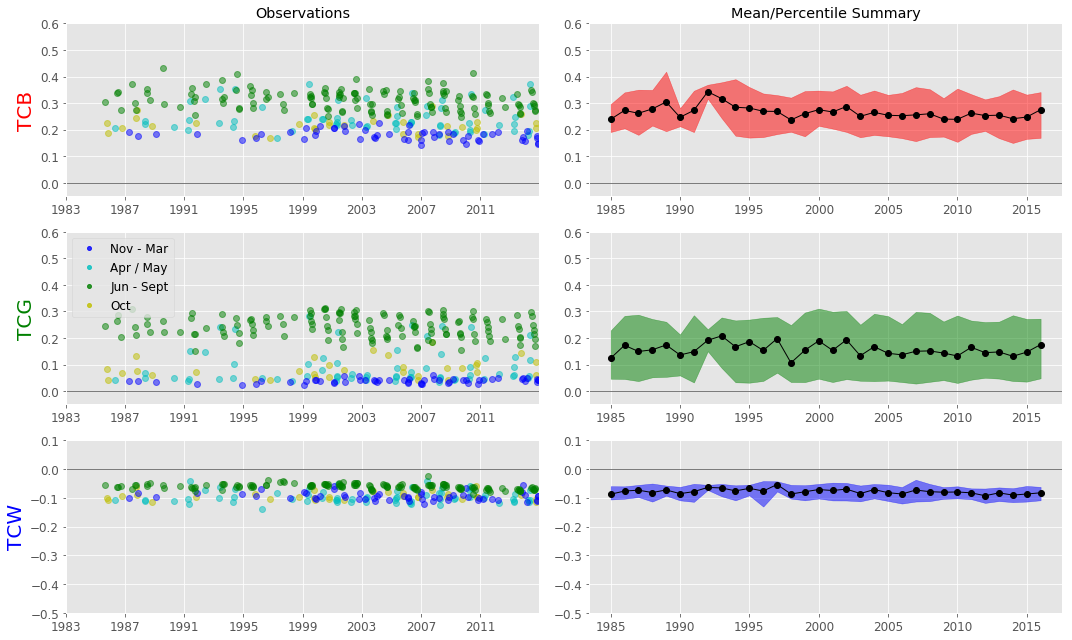

In [136]:
# Time series figure -- 
fig = plt.figure(figsize=(15,9),facecolor='w', edgecolor='k')
plt.style.use('ggplot')

#### TCB ####

### Time series
ax = fig.add_subplot(321)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line
months = np.array([d.month for d in dt_dates_fmask])
for season_months, color, alpha in SEASONS.values():
    season_idx = np.in1d(months, season_months)
    plt.plot(dt_dates_fmask[season_idx], Y_fmask[7][season_idx], marker='o',
             mec=color, mfc=color, alpha=alpha, ls='')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylabel('TCB', fontsize=20, color='r')
plt.ylim((-0.0500, 0.6000))
plt.xlim((xmin, xmax))
plt.title('Observations')

### Summary view
ax = fig.add_subplot(322)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line
plt.plot(TCB_mean, lw=1, color='k', ls='-', marker='o')
plt.fill_between(TCB_iqr_H.keys().levels[0], TCB_iqr_H[:].values, TCB_iqr_L[:].values, color='r', alpha=0.5)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylim((-0.0500, 0.6000))
plt.title('Mean/Percentile Summary')

#### TCG

### Time series
ax = fig.add_subplot(323)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line
months = np.array([d.month for d in dt_dates_fmask])
for season_months, color, alpha in SEASONS.values():
    season_idx = np.in1d(months, season_months)
    plt.plot(dt_dates_fmask[season_idx], Y_fmask[8][season_idx], marker='o',
             mec=color, mfc=color, alpha=alpha, ls='')
plt.ylabel('TCG', fontsize=20, color='g')
plt.ylim((-0.0500, 0.6000))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)  
plt.xlim((xmin, xmax))
plt.legend(handles=[winter, spring, summer, fall], fontsize=12)

### Summary view
ax = fig.add_subplot(324)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line
plt.plot(TCG_mean, lw=1, color='k', ls='-', marker='o')
plt.fill_between(TCG_iqr_H.keys().levels[0], TCG_iqr_H[:].values, TCG_iqr_L[:].values, color='g', alpha=0.5)
plt.ylim((-0.0500, 0.6000))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0) 


#### TCW

### Time series
ax = fig.add_subplot(325)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line
months = np.array([d.month for d in dt_dates_fmask])
for season_months, color, alpha in SEASONS.values():
    season_idx = np.in1d(months, season_months)
    plt.plot(dt_dates_fmask[season_idx], Y_fmask[9][season_idx], marker='o',
             mec=color, mfc=color, alpha=alpha, ls='')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylabel('TCW', fontsize=20, color='b')
plt.ylim((-0.5, 0.1000))
plt.xlim((xmin, xmax))

### Summary view
ax = fig.add_subplot(326)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line
plt.plot(TCW_mean, lw=1, color='k', ls='-', marker='o')
plt.fill_between(TCW_iqr_H.keys().levels[0], TCW_iqr_H[:].values, TCW_iqr_L[:].values, color='b', alpha=0.5)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylim((-0.5, 0.1000))

# Save plots
fig.tight_layout()
plt.savefig('./example_data/{WRS2}_{y}_{x}_TC-summary_{name}.png'.format(WRS2=WRS2, x=px, y=py, name=name))
plt.show()

# Visualize number of observations per year

In [137]:
# Set date limits for TS plots
xmin = dt.datetime.strptime('1985 1', '%Y %j')
xmax = dt.datetime.strptime('2017 365', '%Y %j')

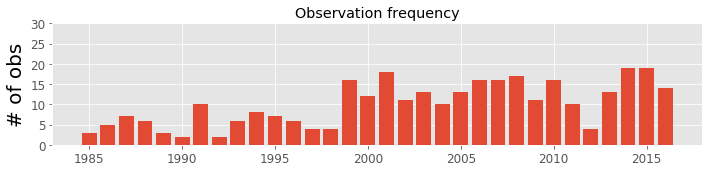

In [138]:
# Number of observations  -- 
fig = plt.figure(figsize=(10,2.5),facecolor='w', edgecolor='k')

plt.bar(TCW_iqr_H.keys().levels[0], nobs.values)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylabel('# of obs', fontsize=20, color='k')
plt.ylim((0, 30))
#plt.xlim((xmin, xmax))
plt.title('Observation frequency')
plt.savefig('./example_data/{WRS2}_{y}_{x}_nobs_{name}.png'.format(WRS2=WRS2, x=px, y=py, name=name))
plt.tight_layout()
plt.show()

# Visualize time series

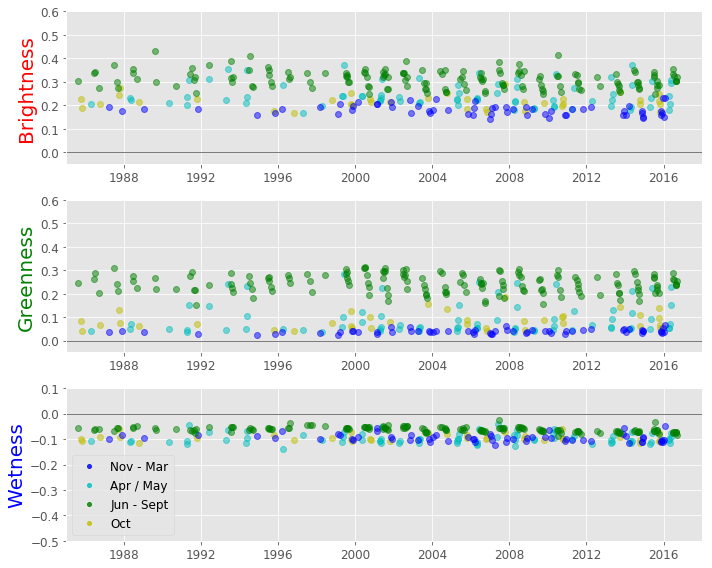

In [139]:
# Time series figure -- 
fig = plt.figure(figsize=(10,8),facecolor='w', edgecolor='k')

#### TCB ####

### Time series
ax = fig.add_subplot(311)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line
months = np.array([d.month for d in dt_dates_fmask])
for season_months, color, alpha in SEASONS.values():
    season_idx = np.in1d(months, season_months)
    plt.plot(dt_dates_fmask[season_idx], Y_fmask[7][season_idx], marker='o',
             mec=color, mfc=color, alpha=alpha, ls='')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylabel('Brightness', fontsize=20, color='r')
plt.ylim((-0.0500, 0.6000))
plt.xlim((xmin, xmax))
plt.title('')

#### TCG

### Time series
ax = fig.add_subplot(312)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line
months = np.array([d.month for d in dt_dates_fmask])
for season_months, color, alpha in SEASONS.values():
    season_idx = np.in1d(months, season_months)
    plt.plot(dt_dates_fmask[season_idx], Y_fmask[8][season_idx], marker='o',
             mec=color, mfc=color, alpha=alpha, ls='')
plt.ylabel('Greenness', fontsize=20, color='g')
plt.ylim((-0.0500, 0.6000))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)  
plt.xlim((xmin, xmax))

#### TCW

### Time series
ax = fig.add_subplot(313)
plt.axhline(0, lw=0.5, color='k', ls='-') # add y=0 reference line  
#plt.axvline(change_date, color='k', ls='--', lw='1.5') # add change date line
#plt.axvline(CCDC_date, color='k', ls='-', lw='1.5') # add CCDC date line
months = np.array([d.month for d in dt_dates_fmask])
for season_months, color, alpha in SEASONS.values():
    season_idx = np.in1d(months, season_months)
    plt.plot(dt_dates_fmask[season_idx], Y_fmask[9][season_idx], marker='o',
             mec=color, mfc=color, alpha=alpha, ls='')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=0)    
plt.ylabel('Wetness', fontsize=20, color='b')
plt.ylim((-0.5, 0.1000))
plt.xlim((xmin, xmax))
plt.legend(handles=[winter, spring, summer, fall], fontsize=12)

plt.tight_layout()

plt.savefig('./example_data/{WRS2}_{y}_{x}_TC-basic_{name}.png'.format(WRS2=WRS2, x=px, y=py, name=name))
plt.show()

